In [32]:

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, froude_krylov_force
from capytaine.bem.solver import BEMSolver
from capytaine.green_functions.delhommeau import Delhommeau
from capytaine.bem.engines import BasicMatrixEngine
from capytaine.bem.problems_and_results import RadiationProblem

cpt.__version__ #requires version 2.0

omega = 0.2
rho = 1025
a0 = 1
wave_num =  (omega**2)/9.81

In [33]:
def generate_body(xyz,type = "Cylinder"):
    if type=="Cylinder":
        mesh1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=5, length=10, center=(xyz[0], xyz[1], xyz[2]))
    else: 
        mesh1 = cpt.meshes.predefined.mesh_sphere(radius=5, center=(xyz[0], xyz[1], xyz[2]))
    body = cpt.FloatingBody(mesh1,
                           cpt.rigid_body_dofs(rotation_center = mesh1.center_of_buoyancy),
                            center_of_mass = mesh1.center_of_buoyancy)
    body.add_translation_dof(name='Heave')
    body = body.immersed_part()
    body.keep_only_dofs(['Heave'])
    body.name = f'{xyz[0]}_{xyz[1]}_{xyz[2]}'
    return body

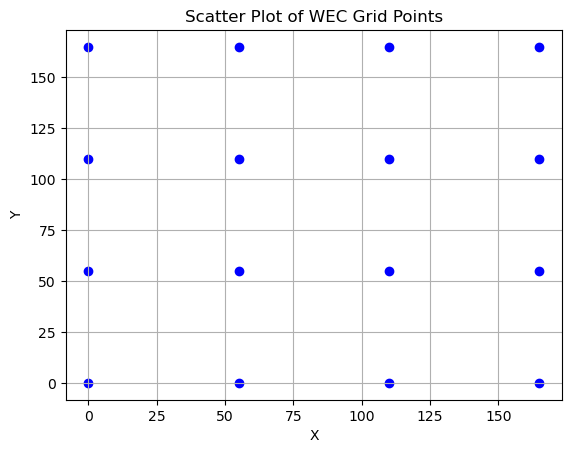

In [34]:
num_bodies = 4 #on each x, and y axis
radius = 5 #update on generate_body as well
distance = 55
grid_range = num_bodies * distance
x_coords,y_coords = np.arange(0,grid_range,distance),np.arange(0,grid_range,distance)
X, Y = np.meshgrid(x_coords, y_coords)
# Flatten the mesh grid coordinates
x_flattened = X.flatten()
y_flattened = Y.flatten()

# Plot the scatter plot
plt.scatter(x_flattened, y_flattened, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of WEC Grid Points')
plt.grid(True)
plt.show()

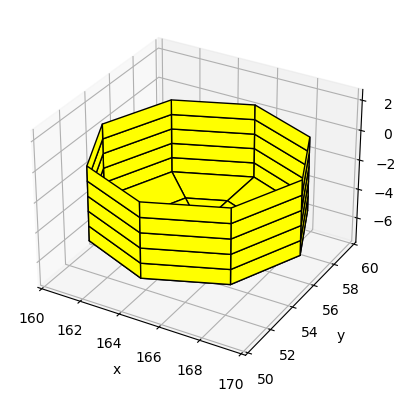

In [35]:

#xyzees = {(0,0,0),(100,0,0)}
xyzees = {(x,y,0) for x,y in zip(x_flattened,y_flattened)}
#mix of sphere and cylinders
bodies = [generate_body(xyz,type = np.random.choice(["Cylinder","Sphere"])) for xyz in xyzees ]
body_to_loc = {body:xyz for xyz,body in zip(xyzees,bodies)}
cache_engine = BasicMatrixEngine(matrix_cache_size=0)
solver = cpt.BEMSolver(engine=cache_engine)

bodies[1].show_matplotlib()


In [36]:


def calculate_theta(I,J): 
    x1,y1= I[0],I[1]
    x2,y2 = J[0], J[1]
    theta = np.arctan2((y2-y1),(x2-x1))
    return theta


def get_neighbors(xyzees):
    neighbor = {xyz:[] for xyz in xyzees}
    for xyz in xyzees:
        for zyx in xyzees:
            if not xyz == zyx:
                neighbor[xyz].append(zyx)
    return neighbor


def get_unit_radiation_data(body,solver):
    '''This function gives A(w) and B(w) for given body'''
    #print("Getting the unit radiation data ")
    radiationProblem = cpt.RadiationProblem(body = body, water_depth = np.infty,
                                      omega=omega) 
    rsolved = solver.solve(radiationProblem)

    dataset = cpt.assemble_dataset([rsolved])

    inertia_matrix = body.compute_rigid_body_inertia().sel(
    influenced_dof='Heave', radiating_dof='Heave'
    ).values
    stiffness = body.compute_hydrostatic_stiffness().sel( 
        influenced_dof='Heave', radiating_dof='Heave').values
    added_mass =  dataset['added_mass'].sel(radiating_dof='Heave', influenced_dof='Heave').values.flatten()[0]
    rad_data = {'A':added_mass,'B':dataset['radiation_damping'].values.flatten()[0],
                'sigma_r':rsolved.sources,'potential':rsolved.potential,
                'I':inertia_matrix, 'stiffness':stiffness,
                'omega':omega}
    
   # print (rad_data)
    return rad_data

def get_unit_diffraction_data(solver,bodyj,bodyi):
    '''This function gives diffraction for given bodyi when interacting with bodyj
      with theta_ij  '''
   # print(f"calculating Diffraction for {bodyi}" and {bodyj})
    theta_ij = calculate_theta(body_to_loc[bodyj], body_to_loc[bodyi]) #theta kj or ji?
   # print(f"for {body_to_loc[bodyj]} and {body_to_loc[bodyi]} is theta = {theta_ij}")
    #whats this when same body..solve regular diffraction
    #F_e_i, S_i
  
    if theta_ij !=0:
      #  print("theta for different ij body diffraction problem")
        diffProblem = cpt.DiffractionProblem(body= bodyi, water_depth = np.infty,
                                        omega=omega, wave_direction = theta_ij ) 
    else:
      #  print("theta for same body diffraction problem")
        diffProblem = cpt.DiffractionProblem(body= bodyi, water_depth = np.infty,
                                        omega=omega, wave_direction = 0.0 ) 
   
         
    solved = solver.solve(diffProblem)
    
       
    diff_data = {'Fe':solved.forces['Heave'] + froude_krylov_force(diffProblem)['Heave'] ,'sigma_d':solved.sources,
                 'potential':solved.potential}
    #print (diff_data)
    return diff_data # for one body combo..run for all ij in main program #for body i


# step 2
# initialize a_ij as a piecewise function with  a_ij= a0 for same body and a_ij = 0 for j!=i.
def init_pseudo_amplitude(bodyi,bodyj,a0 = 1):
    bodyi_loc = body_to_loc[bodyi]
    bodyj_loc = body_to_loc[bodyj]
   
    if bodyi_loc != bodyj_loc:
        a_ij = 0
    else:
        a_ij = 1
    return a_ij

# step 3
# Motion response
def solve_motion_response(rad_unit_data,diff_unit_data_list,a_ij,bodies,bodyi):
      #get unit dataset 
     #print(f"for body {bodyi}")
     Mi = rad_unit_data['I'] 
     Ai  = rad_unit_data['A']
     w = omega
     Bi = rad_unit_data['B']
     Ki = rad_unit_data['stiffness']
     lhs = (w**2)*(-1*(Mi+ Ai)) - 1j* w *Bi + Ki # '-' or '+' ?
     #print(f"for the diff_list in solve motion is {diff_unit_data_list.keys()}")
     #print(lhs)
     rhs = np.sum([a_ij[bodyi] * diff_unit_data_list[bodyi]['Fe'] for j in range(len(bodies)) ])
     
     X_i = rhs/lhs
     #print(f"Calculating Xi value {X_i}")
     return X_i



# Update incident waves amplitude 


def update_compute_potential(rad_unit_data_j, diff_unit_data_j,a_ij_list,X,bodyj,bodies,bodyi):
    ''' only update the amplitude from neighbors'''
    integrand_first = -1j* omega * rad_unit_data_j['sigma_r'] * X 
   # print(f"value of integrand first in {integrand_first}")
    result = []
    for bodyk in bodies:
               #was filtering herre
                   # print(f"{body_to_loc[bodyj]} and {body_to_loc[bodyk]}==>  {a_ij_list[bodyk]}")
                res = a_ij_list[bodyk] * diff_unit_data_j[bodyk]['sigma_d']
                   # print(f"value of both bodies before summing \n {res}")
                result.append(res)
    
   # print(result)
    integrand_second = np.sum(np.array(result),axis = 0)
    integrand = integrand_first + integrand_second
    #print(f"value of integrand second for {bodyj} is => {integrand_second}")
    # print(f"value of integrand{integrand}")
    #transpose it?
    integral = bodyj.mesh.surface_integral(integrand)
   # print(f"Integral by compute_potential {bodyj} is \n {integral}") # this is a scalar representing a potential at the centre
    return (-1/(4*np.pi))* integral

def check_convergence(a_ij, prev_aij,bodies):
    a_ij_all = []
    for bodyi in bodies:
        for bodyj in bodies:
            if bodyi!=bodyj:
                a_ij_all.append(a_ij[bodyi][bodyj] - prev_aij[bodyi][bodyj])
    a_ij_all = np.abs(a_ij_all)
   # print(a_ij_all)
    return np.all(a_ij_all < 0.0001)




def check_resonance(bodyi, bodyj, a_ij, prev_aij, prev_prev_aij):
    resonance = False
    if (np.abs(a_ij[bodyi][bodyj]) > np.abs(prev_aij[bodyi][bodyj])) and (np.abs(a_ij[bodyi][bodyj]) > np.abs(prev_prev_aij[bodyi][bodyj])):
        resonance = True
        print("ALARM OFF _ RESONAANCEEE")
    return resonance




In [50]:

unit_diffraction_data_list = {bodyi:{bodyj:get_unit_diffraction_data(solver,bodyj,bodyi)
                               for bodyj in bodies} for bodyi in bodies}
unit_rad_data_list = {body:get_unit_radiation_data(body,solver) for body in bodies}


a_ij_list = {bodyi:{bodyj:init_pseudo_amplitude(bodyi,bodyj) for bodyj in bodies}  for bodyi in bodies}

#print(a_ij_list)
converged = False


count = 0
while (not converged):
  X_i_list = {body:solve_motion_response(unit_rad_data_list[body],
                                                  unit_diffraction_data_list[body],a_ij_list[body],
                                                  bodies,body) 
                                                    for body in bodies}

  new_phi_ij = {bodyi:{bodyj: update_compute_potential(unit_rad_data_list[bodyj],
                                                    unit_diffraction_data_list[bodyj],
                                                    a_ij_list[bodyj],
                                                    X_i_list[bodyj],
                                                    bodyj,bodies,bodyi) if bodyi!=bodyj else 0 for bodyj in bodies} 
                                                    for bodyi in bodies }
  #including x-xj
 #print ("Phi_ij list")

  e_stuff = {bodyi: {bodyj:(np.exp(1j*wave_num*((body_to_loc[bodyi][0])*np.cos(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi])) + 
                                                      (body_to_loc[bodyi][1])*np.sin(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi]))
                                                        ))) for bodyj in bodies} 
                                                        for bodyi in bodies}

  if count>2:
    prev_prev_aij_list = prev_aij_list
  prev_aij_list = a_ij_list

  if count>2:
    a_ij_list = {bodyi: {bodyj:new_phi_ij[bodyi][bodyj]*omega/(e_stuff[bodyi][bodyj]*9.8) 
                         if check_resonance(bodyi, bodyj,a_ij_list,prev_aij_list,prev_prev_aij_list) else prev_aij_list[bodyi][bodyj]  for bodyj in bodies} 
                                                        for bodyi in bodies }
  else:
    a_ij_list = {bodyi: {bodyj:new_phi_ij[bodyi][bodyj]*omega/(e_stuff[bodyi][bodyj]*9.8)  for bodyj in bodies} 
                                                        for bodyi in bodies }
    
  


  count += 1
  
  converged = check_convergence(a_ij_list,prev_aij_list,bodies)
  
  #print(f"step======================== \n \n {count}")
 
print(f"the loop has succesfully converged? {converged}")
#print(new_phi_ij)

the loop has succesfully converged? True


In [51]:
def get_total_each_body(result_dict, bodies):
    res_each_bodies = {body:[] for body in bodies}
    for bodyi,neighbor in result_dict.items():
        for bodyj,res in neighbor.items():
            if bodyi!=bodyj:
                res_each_bodies[bodyi].append(res)
    return res_each_bodies

phi_each_bodies = get_total_each_body(new_phi_ij,bodies)


In [52]:
diff_problems = {body:cpt.DiffractionProblem(body=body, water_depth = np.infty,
                                      omega=omega, wave_direction=0.) for body in bodies}

rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
                                      omega=omega) for body in bodies}

diff_results = {body:solver.solve(problem) for body,problem in diff_problems.items()}
rad_results = {body:solver.solve(problem) for body,problem in rad_problems.items()}





In [63]:
body_total_phi = {body:np.sum(np.array(phi_each_bodies[body])) for body in phi_each_bodies.keys()}
# + diff_results[body].potential

# body_total_phi

#### Solving single separately to compare the results


### Solving combined (by joining) to compare the results 

In [64]:
# Combine the two individual bodies into a single body.
all_bodies =  bodies[0].join_bodies(*bodies[1:])
#all_bodies.keep_immersed_part()

# The merged body can be used to define the problems in the usual way
problems = [cpt.RadiationProblem(body=all_bodies, radiating_dof=dof, omega=omega) for dof in all_bodies.dofs]
problems = [cpt.DiffractionProblem(body=all_bodies, wave_direction=0.0, omega=omega)]

# Solves the problem
solver = cpt.BEMSolver()
results_all_bodies = [solver.solve(problem) for problem in problems]


### Excitation force for all bodies when Joined

In [65]:
theoretical_joint = {}
for k,v in results_all_bodies[0].forces.items():
    for i,w in froude_krylov_force(problems[0]).items():
        if k==i:
            theoretical_joint[k] = v+w
theoretical_joint


{'0_55_0__Heave': (667178.8729024292-6578.660350833436j),
 '165_55_0__Heave': (521213.35862808087+410523.266040749j),
 '0_110_0__Heave': (667048.9219116734-6576.645050126681j),
 '165_110_0__Heave': (546737.266007541+430637.2414164736j),
 '165_165_0__Heave': (522248.7928403966+411172.87840687763j),
 '0_0_0__Heave': (668319.1801374184-6179.8982957922135j),
 '55_110_0__Heave': (680795.1764825749+148776.61794330383j),
 '110_55_0__Heave': (629102.2544336166+296870.29431579617j),
 '55_165_0__Heave': (682128.5097238513+149301.46330635183j),
 '55_0_0__Heave': (650543.9113559349+142400.56169980927j),
 '165_0_0__Heave': (547843.7115557437+431304.61329055036j),
 '55_55_0__Heave': (680928.3369053972+148810.7583840311j),
 '0_165_0__Heave': (700747.9720714221-6480.650715317309j),
 '110_165_0__Heave': (600962.1464027669+283640.5695426912j),
 '110_0_0__Heave': (601060.183984091+283700.42933899385j),
 '110_110_0__Heave': (629029.9627467636+296839.57315241115j)}

##### excitation force for a individual body

In [66]:
single_simulation = {}
for bodyi,result in diff_results.items():
    for bodyj,prob in diff_problems.items():
        if bodyi==bodyj:
            single_simulation[bodyj] = result.forces['Heave'] + froude_krylov_force(prob)['Heave']


### PWA approximation Either overestimating or underestimating..

the difference between two approximation

In [67]:

def solve(body,PhiPwa,phiD,phiR,phiI):
    total_phi = PhiPwa + phiD + phiR + phiI
    pressure = 1j * omega * rho * total_phi
    force = body.integrate_pressure(pressure)
    return force

phi_Indv = {body:airy_waves_potential(np.array(body_to_loc[body]),diff_problems[body]) for body in bodies}

body_force = {body:solve(body,body_total_phi[body], 
                         unit_diffraction_data_list[body][body]['potential'],
                         unit_rad_data_list[body]['potential'], phi_Indv[body]
                         ) for body in  bodies}
# + diff_results[body].potential



Interaction is captured by PWA at that distance.

Sometime it overestimates and underestimates..but a lot closer to than if just using individual ones

In [68]:

import pandas as pd 
merged_dict = {}
for key in body_force.keys():
    merged_dict[key] = [key.mesh.name.split("_")[0],body_force[key]['Heave'], single_simulation[key], theoretical_joint[key.name+"__Heave"]]

# Create a pandas DataFrame from the merged dictionary
df = pd.DataFrame(merged_dict, index=["Type",'PWA', 'Single', 'Joint'])

# Transpose the DataFrame to have keys as columns
df = df.transpose()
df['Error_PWA_Joint'] = 100*(df['PWA'] - df['Joint'])/df['Joint']
df['Error_Single_Joint'] = 100*np.abs(df['Single'] - df['Joint'])/df['Joint']
df.head()

,Type,PWA,Single,Joint,Error_PWA_Joint,Error_Single_Joint
0_55_0,cylinder,(680383.0028744703-1032.1314921866997j),(669993.4070150929-336.07812765173105j),(667178.8729024292-6578.660350833436j),(1.970709964757728+0.8507726194978423j),(1.026271464152165+0.010119462208146078j)
165_55_0,cylinder,(527816.5572115446+435957.2122148976j),(524204.9153645288+417253.5022020391j),(521213.35862808087+410523.266040749j),(3.1538236371210293+2.3957111166032803j),(0.8720763427068822-0.6868734703715876j)
0_110_0,cylinder,(680383.0028744703-1032.1314921866906j),(669993.4070150929-336.0781276517259j),(667048.9219116734-6576.645050126681j),(1.990577408895744+0.8508261661387676j),(1.0343570522424554+0.01019805139358988j)
165_110_0,sphere,(548530.1576522619+453902.0807680001j),(549771.2569742048+437486.7602108406j),(546737.266007541+430637.2414164736j),(2.2707734350713125+2.466640580474226j),(0.845598318201138-0.666034949027098j)
165_165_0,cylinder,(527816.5572115446+435957.2122148976j),(524204.9153645288+417253.50220203906j),(522248.7928403966+411172.87840687763j),(2.9647348149878763+2.411522727243985j),(0.7550524649859928-0.5944620641208012j)


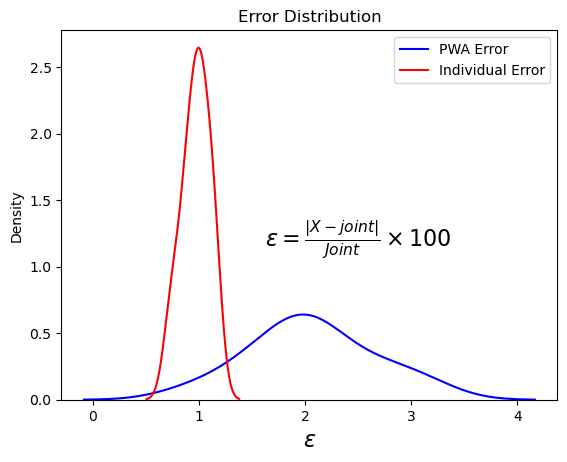

In [69]:
# Extract the real part of the complex values for each column
import seaborn as sns
temp_df = pd.DataFrame()
temp_df['Error_PWA_Joint'] = df['Error_PWA_Joint'].apply(lambda x: x.real)
temp_df['Error_Single_Joint'] = df['Error_Single_Joint'].apply(lambda x: x.real)

# Plot KDE distribution for each column with different colors
sns.kdeplot(data=temp_df['Error_PWA_Joint'], color='blue', label='PWA Error')
sns.kdeplot(data=temp_df['Error_Single_Joint'], color='red', label='Individual Error')

# Adding labels and title
plt.xlabel(r'$\epsilon$',fontsize = 16)
plt.ylabel('Density')
plt.title('Error Distribution')
plt.text(2.5, 1.2, r'$\epsilon = \frac{|X-joint|}{Joint} \times 100$', fontsize=16, ha='center', va='center')

# Adding a legend
plt.legend()

# Show the plot
plt.show()


### Conclusion

So it seems when we have PWA very accurate for some bodies and not so for others. 

I am guessing depending on the distance it overextimates and underestimates and is dead accurate for some.

In [70]:
# import matplotlib.pyplot as plt
# # Plotting the DataFrame as a bar plot
# df.set_index('Type', inplace=True)
# ax = df.plot(kind='bar', rot=0)

# # Adding labels and title
# plt.xlabel('Calculation')
# plt.ylabel('Real(Exciting force)')
# plt.title('Comparison for few bodies')
# # Rotate X-axis ticks
# plt.xticks(rotation=90)
# # Show the plot
# plt.show()

#### Hybrid Model? PWA + some other terms?

A regression model $Y(theretical)  = f(x(single)) + f(x(joint))$



In [71]:

import pandas as pd
from sklearn.linear_model import LinearRegression


# Split the DataFrame into input features (X) and target variable (y)
X = df[['PWA', 'Single']].applymap(lambda x: x.real)
y = df['Joint'].apply(lambda x: x.real)

# Create a linear regression model
model = LinearRegression()

# Fit the model with the data
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Print the predictions
print(predictions)


[667297.2925671  521766.41784321 667297.2925671  546656.45022907
 521766.41784321 667297.2925671  681640.82177423 629966.52140663
 681640.82177423 650623.94207139 546656.45022907 681640.82177423
 699091.37067981 601290.06167833 601290.06167833 629966.52140663]


/Users/qe5106hi/miniconda3/envs/WEC_array/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


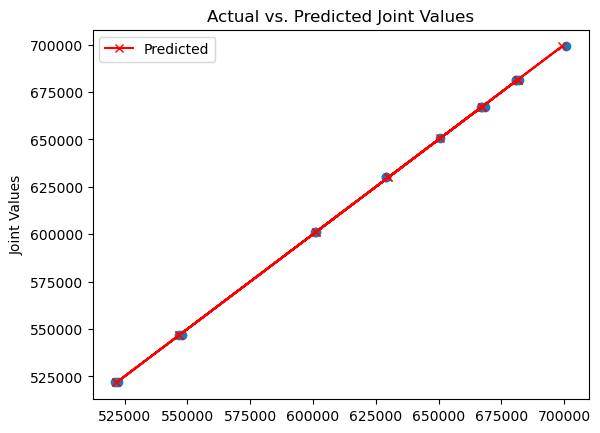

In [72]:
# Plotting the actual 'Joint' values and predicted values
plt.scatter(df['Joint'],predictions)
plt.plot(predictions, predictions, c='red', label='Predicted', marker='x')

# plt.scatter(df.index, predictions, label='Predicted', marker='x', color='red')
# plt.scatter(df.index, df['Single'], label='Individual', marker='*', color='green')
# Adding labels and title
plt.xlabel('')
plt.ylabel('Joint Values')
plt.title('Actual vs. Predicted Joint Values')

# Adding a legend
plt.legend()

# Show the plot
plt.show()